In [1]:
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from rdkit import Chem
import torch.nn.functional as F
import torch
import pandas as pd
from math import sqrt
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

In [2]:
from clsar.dataset import LSSNS
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures

In [4]:
G = GenAttentiveFeatures()

In [40]:
for dataset_name in LSSNS.names.keys():
    print(dataset_name)

for dataset_name in MoleculeNet.names.keys():
    print(dataset_name)

ur2
plk1
rip2
rorg
klk5
braf
usp7
phgdh
notum
rxfp1
mglur2
pkci
eaat3
esol
freesolv
lipo
pcba
muv
hiv
bace
bbbp
tox21
toxcast
sider
clintox


In [41]:
dataset_name = 'phgdh'
Dataset = LSSNS  # MoleculeNet
epochs = 800
batch_size = 128
lr=10**-4

In [42]:
pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '/tmp/data1'

# use the attentiveFP node and edge features during the mol-2-graph transoformation
#dataset = LSSInhibitor(path, name=dataset_name, pre_transform=GenAttentiveFeatures()).shuffle()
dataset = Dataset(path, name=dataset_name,
                  pre_transform=pre_transform).shuffle()

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr,
                             weight_decay=10**-5)


def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index,
                    data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index,
                    data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())


history1 = []
for epoch in range(1, epochs):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')

    history1.append({'Epoch': epoch, 'train_rmse': train_rmse,
                    'val_rmse': val_rmse, 'test_rmse': test_rmse})

pd.DataFrame(history1).to_csv('./test/%s_%s.csv' % (dataset_name, in_channels))

Epoch: 001, Loss: 6.4657 Val: 6.2176 Test: 6.5277
Epoch: 002, Loss: 6.2474 Val: 5.9911 Test: 6.4557
Epoch: 003, Loss: 6.1245 Val: 5.7525 Test: 6.1902
Epoch: 004, Loss: 5.8562 Val: 5.5290 Test: 5.9598
Epoch: 005, Loss: 5.7298 Val: 5.4386 Test: 5.7219
Epoch: 006, Loss: 5.5070 Val: 5.1603 Test: 5.5408
Epoch: 007, Loss: 5.2069 Val: 5.0438 Test: 5.5140
Epoch: 008, Loss: 5.0998 Val: 4.7836 Test: 5.3131
Epoch: 009, Loss: 4.8198 Val: 4.5126 Test: 4.9778
Epoch: 010, Loss: 4.6525 Val: 4.5222 Test: 4.7082
Epoch: 011, Loss: 4.4376 Val: 4.1613 Test: 4.4762
Epoch: 012, Loss: 4.2070 Val: 4.0717 Test: 4.3338
Epoch: 013, Loss: 3.9648 Val: 3.8793 Test: 4.0260
Epoch: 014, Loss: 3.7313 Val: 3.4948 Test: 3.8938
Epoch: 015, Loss: 3.5915 Val: 3.2438 Test: 3.6350
Epoch: 016, Loss: 3.2970 Val: 2.8155 Test: 3.2363
Epoch: 017, Loss: 3.0217 Val: 2.7616 Test: 3.2418
Epoch: 018, Loss: 2.6820 Val: 2.4280 Test: 2.8607
Epoch: 019, Loss: 2.5015 Val: 2.1333 Test: 2.6971
Epoch: 020, Loss: 2.0567 Val: 1.9396 Test: 2.0856


In [43]:
pre_transform = GenAttentiveFeatures()
in_channels = 39
path = '/tmp/data0'

# use the attentiveFP node and edge features during the mol-2-graph transoformation
#dataset = LSSInhibitor(path, name=dataset_name, pre_transform=GenAttentiveFeatures()).shuffle()
dataset = Dataset(path, name=dataset_name,
                  pre_transform=pre_transform).shuffle()


# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=10**-5)


def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index,
                    data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index,
                    data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())


history2 = []
for epoch in range(1, epochs):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')

    history2.append({'Epoch': epoch, 'train_rmse': train_rmse,
                    'val_rmse': val_rmse, 'test_rmse': test_rmse})

pd.DataFrame(history2).to_csv('./test/%s_%s.csv' % (dataset_name, in_channels))

Epoch: 001, Loss: 5.8341 Val: 5.6301 Test: 4.6552
Epoch: 002, Loss: 5.6839 Val: 5.5084 Test: 4.5667
Epoch: 003, Loss: 5.5124 Val: 5.3383 Test: 4.3210
Epoch: 004, Loss: 5.3488 Val: 5.1400 Test: 4.2381
Epoch: 005, Loss: 5.2254 Val: 4.9720 Test: 4.0233
Epoch: 006, Loss: 5.0300 Val: 4.9949 Test: 3.8533
Epoch: 007, Loss: 4.8716 Val: 4.7158 Test: 3.6885
Epoch: 008, Loss: 4.6679 Val: 4.6005 Test: 3.6849
Epoch: 009, Loss: 4.5091 Val: 4.3313 Test: 3.4892
Epoch: 010, Loss: 4.3897 Val: 4.3014 Test: 3.1751
Epoch: 011, Loss: 4.2342 Val: 4.0358 Test: 3.0478
Epoch: 012, Loss: 4.0256 Val: 3.9802 Test: 2.7909
Epoch: 013, Loss: 3.7498 Val: 3.6123 Test: 2.5882
Epoch: 014, Loss: 3.5078 Val: 3.4102 Test: 2.5198
Epoch: 015, Loss: 3.3526 Val: 3.0311 Test: 2.3223
Epoch: 016, Loss: 3.0509 Val: 2.8703 Test: 1.8113
Epoch: 017, Loss: 2.7281 Val: 2.3880 Test: 1.8069
Epoch: 018, Loss: 2.5795 Val: 2.2988 Test: 1.6595
Epoch: 019, Loss: 2.4554 Val: 2.3090 Test: 1.2399
Epoch: 020, Loss: 2.0544 Val: 1.8587 Test: 0.9781


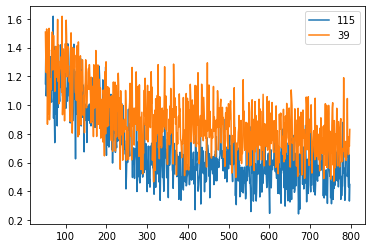

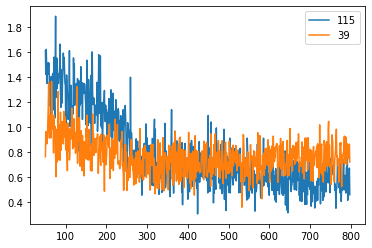

In [44]:
df1 = pd.DataFrame(history1)
df2 = pd.DataFrame(history2)

ax = df1.val_rmse.to_frame('115').join(
    df2.val_rmse.to_frame('39')).iloc[50:].plot()
ax = df1.test_rmse.to_frame('115').join(
    df2.test_rmse.to_frame('39')).iloc[50:].plot()

In [45]:
from torchviz import make_dot
for data in train_loader:
    pass

model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2)
out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
make_dot(out, params=dict(list(model.named_parameters()))
         ).render("./test/model_torchviz", format="png")

'test/model_torchviz.png'